# BiomedParse Inference Demo Notebook

Welcome to the demo notebook for BiomedParse, a comprehensive tool for biomedical image analysis. BiomedParse is designed to simultaneously handle segmentation, detection, and recognition tasks across major biomedical image modalities, providing a unified solution for complex image analysis in biomedical research.

[[`Paper`](https://aka.ms/biomedparse-paper)] [[`Demo`](https://microsoft.github.io/BiomedParse/)] [[`Model`](https://huggingface.co/microsoft/BiomedParse)]  [[`Data`](https://huggingface.co/datasets/microsoft/BiomedParseData)]

## Model Checkpoint Access

The BiomedParse model checkpoint is hosted on [HuggingFace](https://huggingface.co/microsoft/BiomedParse). To access the model:

1. Visit the [model page](https://huggingface.co/microsoft/BiomedParse).
2. Make sure to review and accept the terms of use to gain access to the checkpoint.
3. Retrieve your HuggingFace access token from your user profile.

## Setting Up Access

To use the model, set your Hugging Face access token in the HF_TOKEN environment variable or as a Colab secret. This step ensures secure and authorized access to the model resources.

In [ ]:
# Set your Hugging Face access token in your environment
# import os
# os.environ['HF_TOKEN'] = 'your_huggingface_access_token_here'

# Or, if you are using Google Colab, set HF_TOKEN on Colab secrets.

In [1]:
# from google.colab import userdata
# import huggingface_hub

# huggingface_hub.login(userdata.get('HF_TOKEN'))

In [2]:
# from huggingface_hub import hf_hub_download

# model_file = hf_hub_download(repo_id="microsoft/BiomedParse", filename="biomedparse_v1.pt", local_dir="pretrained")

# print(f"Downloaded model file to: {model_file}")

## Environment Setup

In [3]:
# !git clone https://github.com/microsoft/BiomedParse

In [4]:
# !pip install -r BiomedParse/assets/requirements/requirements.txt

# Restart Colab Runtime

In [5]:
# Make sure to restart Colab runtime after installing dependencies
import os
try:
    import google.colab
    os._exit(0)
except ImportError:
    pass

In [6]:
# import os
# os.chdir('/content/BiomedParse')
# print(os.getcwd())

## Load the model weights

In [ ]:
from PIL import Image
import torch
import argparse
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed # changed from utils
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image

conf_files = "configs/biomedparse_inference.yaml"
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = "/m-kraken/kraken/nobackup/zucksliu/biomedparse_ckpt/output/biomed_seg_lang_v1.yaml_conf~/all_CFP/00366020/default/model_state_dict.pt"

model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/homes/gws/zucksliu/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'nltk'

# Run Inference

In [ ]:
# RGB image input of shape (H, W, 3). Currently only batch size 1 is supported.
image = Image.open('/m-kraken/kraken/nobackup/zucksliu/my_biomedparse_dataset/my_dataset_all_CFP/test/FIVES162N_CFP_eyes.png', formats=['png'])
image = image.convert('RGB')

# text prompts querying objects in the image. Multiple ones can be provided.
prompts = ['arteries', 'veins']

pred_mask = interactive_infer_image(model, image, prompts)
pred_mask.shape

NameError: name 'Image' is not defined

In [ ]:
# load ground truth mask
gt_masks = []
for prompt in prompts:
    gt_mask = Image.open("/m-kraken/kraken/nobackup/zucksliu/my_biomedparse_dataset/my_dataset_all_CFP/test_mask/FIVES162N_CFP_eyes_vessel.png", formats=['png'])
    gt_mask = 1*(np.array(gt_mask.convert('RGB'))[:,:,0] > 0)
    gt_masks.append(gt_mask)

# prediction with ground truth mask
for i, pred in enumerate(pred_mask):
    gt = gt_masks[i]
    dice = (1*(pred>0.5) & gt).sum() * 2.0 / (1*(pred>0.5).sum() + gt.sum())
    print(f'Dice score for {prompts[i]}: {dice:.4f}')

Dice score for vessel: 0.7376


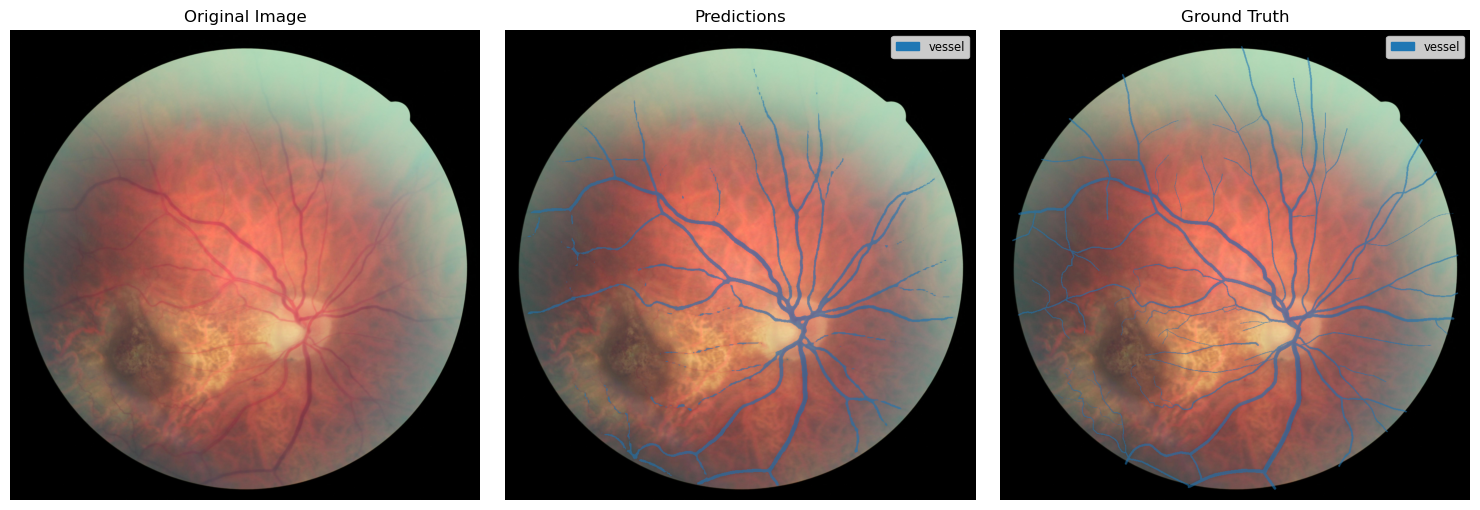

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as mpatches

def overlay_masks(image, masks, colors):
    overlay = image.copy()
    overlay = np.array(overlay, dtype=np.uint8)
    for mask, color in zip(masks, colors):
        overlay[mask > 0] = (overlay[mask > 0] * 0.4 + np.array(color) * 0.6).astype(np.uint8)
    return Image.fromarray(overlay)

def generate_colors(n):
    cmap = plt.get_cmap('tab10')
    colors = [tuple(int(255 * val) for val in cmap(i)[:3]) for i in range(n)]
    return colors

original_image = Image.open('/m-kraken/kraken/nobackup/zucksliu/my_biomedparse_dataset/my_dataset_all_CFP/test/FIVES162N_CFP_eyes.png').convert('RGB')

colors = generate_colors(len(prompts))

pred_overlay = overlay_masks(original_image, [1*(pred_mask[i] > 0.5) for i in range(len(prompts))], colors)

gt_overlay = overlay_masks(original_image, gt_masks, colors)

legend_patches = [mpatches.Patch(color=np.array(color) / 255, label=prompt) for color, prompt in zip(colors, prompts)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(pred_overlay)
axes[1].set_title("Predictions")
axes[1].axis('off')
axes[1].legend(handles=legend_patches, loc='upper right', fontsize='small')

axes[2].imshow(gt_overlay)
axes[2].set_title("Ground Truth")
axes[2].axis('off')
axes[2].legend(handles=legend_patches, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()